<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_seminario_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Carga de Librerias

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jUsI1u3bDkgVyIEuVXaxjEMp_VeEKQvc' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jUsI1u3bDkgVyIEuVXaxjEMp_VeEKQvc" -O encoder2.zip && rm -rf /tmp/cookies.txt
!unzip /content/encoder2.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ju7FwlpdeuROeRFjyq34I8UAp6aVwsY6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ju7FwlpdeuROeRFjyq34I8UAp6aVwsY6" -O decoder2.zip && rm -rf /tmp/cookies.txt
!unzip /content/decoder2.zip
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import random
AUDIO_LOAD = []
etiquetas = []
track_num = []

# En la siguente celda puedes subir tus archivos.
1. Escoge el nombre del grupo de audios.
2. Evalúa la celda.
3. Repite hasta tener todos los conjuntos que necesites

In [3]:
#@title Carga de archivos
## 

from google.colab import files
#@ tectInserta
text = 'fm' #@param {type:"string"}
#AUDIO_LOAD = []
sr16k = 16000
secs = 1
uploaded = files.upload()
track_num.append(len(uploaded))
for idx, track in enumerate(uploaded.keys()):
  print(track)
  if track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      etiquetas.append(text)
      AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
      

Saving fm_0.wav to fm_0.wav
Saving fm_1.wav to fm_1.wav
Saving fm_2.wav to fm_2.wav
Saving fm_3.wav to fm_3.wav
Saving fm_4.wav to fm_4.wav
Saving fm_5.wav to fm_5.wav
fm_0.wav
fm_1.wav
fm_2.wav
fm_3.wav
fm_4.wav
fm_5.wav


En la siguiente celda podrás visualizar una tabla con múltiples características que los describen

In [4]:
#@title DATASET

DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

,gid,id,trackname,data,fft,f0
0,am,am0,am_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10.88733994865394, 18.003132014177258, 17.133...",123.132642
1,am,am1,am_1.wav,"[-0.00012755481, -0.00027333797, -0.0003318499...","[4.826169980671536, 7.7907391918155415, 13.473...",176.187423
2,am,am2,am_2.wav,"[-0.012188385, -0.019903447, -0.017293891, -0....","[6.027088620568621, 21.105482632333583, 26.331...",138.010754
3,am,am3,am_3.wav,"[-0.08786263, -0.1444907, -0.1269547, -0.13857...","[13.619418120163562, 17.424121442392728, 20.80...",62.405630
4,am,am4,am_4.wav,"[0.0022773542, 0.0052165333, 0.0066018347, 0.0...","[8.31099506332251, 15.920505881101485, 17.6610...",172.594494
5,am,am5,am_5.wav,"[0.00010236748, 0.00016448542, 0.00013889164, ...","[11.644083565417443, 14.18238529306918, 22.288...",149.652938
6,fm,fm0,fm_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.454912725677432, -8.373184263866577, -6.10...",81.960707
7,fm,fm1,fm_1.wav,"[0.025129607, 0.043615725, 0.04222123, 0.04870...","[2.218131057360571, 3.4567507357789706, 4.5381...",189.012737
8,fm,fm2,fm_2.wav,"[4.924257e-05, -0.00019987492, -0.00015007818,...","[-51.46414685757855, -29.752441595836927, -40....",2233.535982
9,fm,fm3,fm_3.wav,"[0.028035654, 0.044978045, 0.03788065, 0.04021...","[1.8492719266670963, 1.8015120283094899, 1.827...",87.675389


In [5]:
#@title Filtrado
zliders = dict(DATA['gid'].value_counts())
color = list(np.random.choice(np.random.randint(0,30),len(zliders),replace = False))
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))

ui = widgets.VBox(sliders)

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
  print(DATA_filt['gid'])
  return DATA_filt


out = widgets.interactive_output(datafilter, update_sliders)
updated_df = datafilter
display(ui,out)

Output()

In [6]:
#@title DATASET
dframes = []
for key, value in update_sliders.items():
  dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
  #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
audiotracks = dict(zip(DATA_filt['id'],DATA_filt['id'].index))
DATA_filt

,level_0,index,gid,id,trackname,data,fft,f0
0,0,0,am,am0,am_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10.88733994865394, 18.003132014177258, 17.133...",123.132642
1,1,1,am,am1,am_1.wav,"[-0.00012755481, -0.00027333797, -0.0003318499...","[4.826169980671536, 7.7907391918155415, 13.473...",176.187423
2,2,2,am,am2,am_2.wav,"[-0.012188385, -0.019903447, -0.017293891, -0....","[6.027088620568621, 21.105482632333583, 26.331...",138.010754
3,3,3,am,am3,am_3.wav,"[-0.08786263, -0.1444907, -0.1269547, -0.13857...","[13.619418120163562, 17.424121442392728, 20.80...",62.405630
4,4,4,am,am4,am_4.wav,"[0.0022773542, 0.0052165333, 0.0066018347, 0.0...","[8.31099506332251, 15.920505881101485, 17.6610...",172.594494
5,5,5,am,am5,am_5.wav,"[0.00010236748, 0.00016448542, 0.00013889164, ...","[11.644083565417443, 14.18238529306918, 22.288...",149.652938
6,0,6,fm,fm0,fm_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.454912725677432, -8.373184263866577, -6.10...",81.960707
7,1,7,fm,fm1,fm_1.wav,"[0.025129607, 0.043615725, 0.04222123, 0.04870...","[2.218131057360571, 3.4567507357789706, 4.5381...",189.012737
8,2,8,fm,fm2,fm_2.wav,"[4.924257e-05, -0.00019987492, -0.00015007818,...","[-51.46414685757855, -29.752441595836927, -40....",2233.535982
9,3,9,fm,fm3,fm_3.wav,"[0.028035654, 0.044978045, 0.03788065, 0.04021...","[1.8492719266670963, 1.8015120283094899, 1.827...",87.675389


variance: 
[0.92967987 0.04406958]


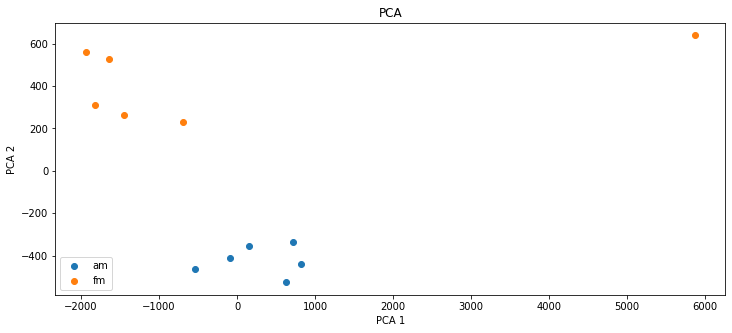

In [135]:
#@title Visualización de datos { run: "auto" }
ids = list(DATA_filt['id'])
audio_viz = 'PCA' #@param ['PCA','F0', 'histogram']
fig, ax = plt.subplots()
fig.set_size_inches([12,5])
if audio_viz == 'histogram':
  ax = DATA_filt['gid'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  plt.show()
if audio_viz == 'PCA':
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0
  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  #for idx, id in enumerate(ids):
  #  ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  fig.add_axes(ax)
  plt.legend()
  plt.title('PCA')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.show()
  


In [ ]:
#@title Entrenamiento del modelo

from google.colab import files
##standarizacion de datos
data = np.vstack(DATA_filt['data'])
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]
Xw = (data- mu_wave)/max_wave
Xw = Xw[...,np.newaxis][...,np.newaxis]

referencia_1 = 'Preentrenado' #@param ['Nuevo modelo','Preentrenado','mi modelo']
Epocas = 10 #@param {type:"slider", min:10, max:10000, step:1}

batches = 20 #@param {type: "integer"}
lr = 0.00008 #@param {type: "slider", min:0.00001, max: 0.0001, step:0.00001}
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
if referencia_1 == 'Preentrenado': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/encoder2',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/decoder2',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])

if referencia_1 == 'Nuevo modelo': 
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
else:
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)




1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


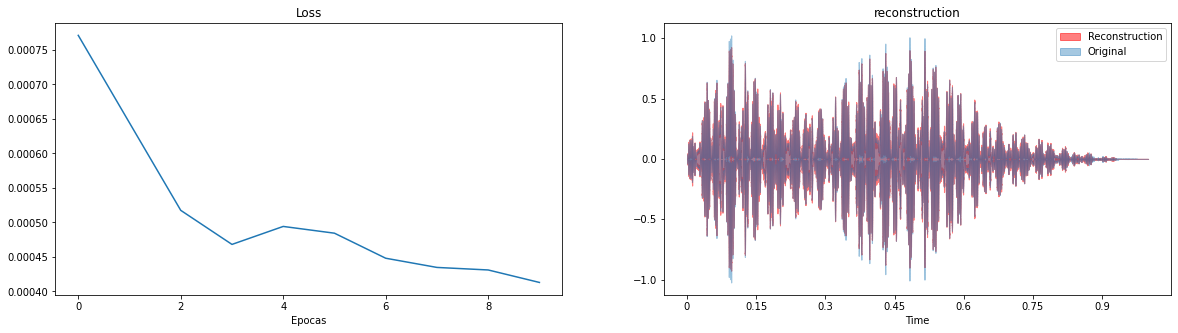

In [165]:
#@title Evaluación del modelo
#una visualización donde se vea la curva del modelo junto a la recunstruccion


def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  recons = decoder_pretrained.predict(latent_gen[0][0:])
  recons= recons[0].flatten()
  return latent_gen, recons

def gps_latent(dic_tracks, df, data):
  '''search all track ids position in the latent space in an ''orderly fashion'' '''
  res_latent = []
  for key in dic_tracks.keys():
    res_latent.append(latent_search(key, df, data)[0])
  return res_latent

all_tracks_latent = gps_latent(audiotracks, DATA_filt, Xw)



track = random.choices(ids)[0]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].plot(tr_logs.history['loss'])
librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')
ax[1].legend()
ax[0].set_xlabel("Epocas")
ax[0].set_title('Loss')
ax[1].set_title('reconstruction')


####archivos de audio
IPython.display.display(IPython.display.Audio(Xw[audiotracks[track]].flatten(), rate = sr16k))
IPython.display.display(IPython.display.Audio(latent_search(track, DATA_filt, Xw)[1],rate = sr16k))

In [169]:
def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  recons = decoder_pretrained.predict(latent_gen[0][0:])
  recons= recons[0].flatten()
  return latent_gen[0], recons 

In [ ]:
len(all_tracks_latent)
all_tracks_latent[0]

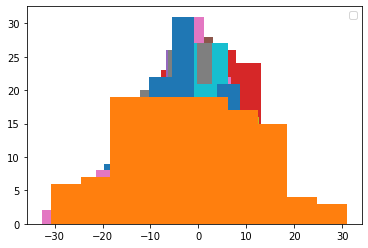

In [196]:
fig, ax = plt.subplots()
for z in all_tracks_latent[0:]:
    #print(key,value)
    ax.hist(z[0][0],linestyle= '--')

ax.legend()

1/1 [==============================] - 0s 16ms/step


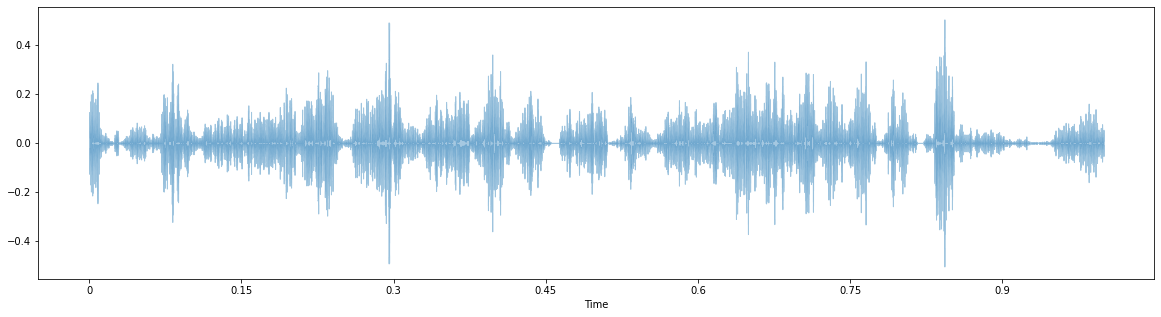

In [237]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)
audio_random = np.random.normal(0,30, size= (2,128))
recons = decoder_pretrained.predict(audio_random)
recons= recons[0].flatten()
librosa.display.waveshow(recons, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(recons, rate = sr16k))


In [226]:
audio_random = np.random.normal(0,20, size= 128)
audio_random.shape

(128,)

In [ ]:
fig, ax = plt.subplots()
for z in all_tracks_latent[0:]:
    #print(key,value)
    ax.hist(z[0][0],linestyle= '--')

ax.legend()

In [207]:
a = all_tracks_latent[0][0][7].sum()
a

-144.35236

In [200]:
stats = pd.DataFrame(all_tracks_latent[0][0])
stats

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-16.366730,7.154947,-7.093828,1.334834,3.380860,0.487054,1.994498,-13.970891,16.578510,-2.556106,...,10.803480,9.227657,0.091919,6.436892,3.021964,8.694371,4.724779,1.696780,7.650950,7.669818
1,-12.310459,1.288660,-3.354300,-1.299454,13.395391,-3.611458,0.709373,3.749879,13.601459,4.094798,...,4.306416,-16.254473,-0.366965,7.405978,-7.313181,-8.774692,7.727627,-3.358316,0.604476,1.559061
2,-14.454377,9.335001,6.290422,-0.964310,0.060005,-5.460509,1.680363,-5.190209,3.472582,0.393824,...,2.490927,-6.476742,9.344702,-0.628917,-2.072207,-1.985755,7.753514,8.503145,-3.111575,5.781028
3,-1.411280,-7.888252,16.079994,11.372190,-4.928634,5.105684,8.435265,10.087662,5.437855,-3.164259,...,11.516341,4.444652,9.045118,11.640490,0.512453,-5.699043,-5.259046,3.536995,10.114745,-10.471674
4,6.027029,-6.246209,7.672515,-2.598722,-3.915048,-10.898768,0.819781,8.138160,-3.670618,10.532446,...,3.349405,9.412152,-10.264734,-1.796380,-6.053040,-3.547664,1.378436,-1.058173,-3.499968,-3.879783
5,0.293753,-5.911037,-2.746598,-2.641963,-2.220425,-12.381471,-5.069141,1.882842,3.115650,7.637305,...,5.961021,-6.693404,-1.594992,-4.079840,-0.119413,0.037355,-1.321572,8.180198,-9.312142,-5.983994
6,-14.715158,-11.692465,8.067016,9.507013,-2.057238,0.487733,-2.159275,-23.153307,4.783585,-11.822364,...,-2.090161,-10.104670,2.982896,21.635941,-4.467140,-10.637872,0.061407,-14.910219,-6.427498,-8.336732
7,-7.021503,4.413863,13.019536,-25.300337,-1.662809,4.103855,-14.531795,1.687842,-2.014722,3.346697,...,10.266124,0.529738,-0.638789,6.413842,-16.452332,11.316013,10.416951,-8.816525,0.943982,-14.373971
8,-2.545990,-5.029787,-12.300461,-3.436769,13.528653,-5.849571,-2.700623,6.721046,2.205525,1.919534,...,-4.505040,-1.395904,2.909683,15.520389,-0.853865,5.695907,8.001395,-7.258782,4.747821,8.831929
9,-4.324613,2.202029,4.522805,6.264214,-12.320798,4.260358,-0.014612,-2.805096,-1.155165,10.714123,...,7.151198,9.645579,0.864055,-0.648043,8.239562,1.708569,0.508434,-0.050502,-0.695075,4.067647


In [243]:
stats['ids'] = DATA_filt['id']
stats.set_index('ids')

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,ids
0,-16.366730,7.154947,-7.093828,1.334834,3.380860,0.487054,1.994498,-13.970891,16.578510,-2.556106,...,9.227657,0.091919,6.436892,3.021964,8.694371,4.724779,1.696780,7.650950,7.669818,am0
1,-12.310459,1.288660,-3.354300,-1.299454,13.395391,-3.611458,0.709373,3.749879,13.601459,4.094798,...,-16.254473,-0.366965,7.405978,-7.313181,-8.774692,7.727627,-3.358316,0.604476,1.559061,am1
2,-14.454377,9.335001,6.290422,-0.964310,0.060005,-5.460509,1.680363,-5.190209,3.472582,0.393824,...,-6.476742,9.344702,-0.628917,-2.072207,-1.985755,7.753514,8.503145,-3.111575,5.781028,am2
3,-1.411280,-7.888252,16.079994,11.372190,-4.928634,5.105684,8.435265,10.087662,5.437855,-3.164259,...,4.444652,9.045118,11.640490,0.512453,-5.699043,-5.259046,3.536995,10.114745,-10.471674,am3
4,6.027029,-6.246209,7.672515,-2.598722,-3.915048,-10.898768,0.819781,8.138160,-3.670618,10.532446,...,9.412152,-10.264734,-1.796380,-6.053040,-3.547664,1.378436,-1.058173,-3.499968,-3.879783,am4
5,0.293753,-5.911037,-2.746598,-2.641963,-2.220425,-12.381471,-5.069141,1.882842,3.115650,7.637305,...,-6.693404,-1.594992,-4.079840,-0.119413,0.037355,-1.321572,8.180198,-9.312142,-5.983994,am5
6,-14.715158,-11.692465,8.067016,9.507013,-2.057238,0.487733,-2.159275,-23.153307,4.783585,-11.822364,...,-10.104670,2.982896,21.635941,-4.467140,-10.637872,0.061407,-14.910219,-6.427498,-8.336732,fm0
7,-7.021503,4.413863,13.019536,-25.300337,-1.662809,4.103855,-14.531795,1.687842,-2.014722,3.346697,...,0.529738,-0.638789,6.413842,-16.452332,11.316013,10.416951,-8.816525,0.943982,-14.373971,fm1
8,-2.545990,-5.029787,-12.300461,-3.436769,13.528653,-5.849571,-2.700623,6.721046,2.205525,1.919534,...,-1.395904,2.909683,15.520389,-0.853865,5.695907,8.001395,-7.258782,4.747821,8.831929,fm2
9,-4.324613,2.202029,4.522805,6.264214,-12.320798,4.260358,-0.014612,-2.805096,-1.155165,10.714123,...,9.645579,0.864055,-0.648043,8.239562,1.708569,0.508434,-0.050502,-0.695075,4.067647,fm3


In [1]:
stats2 = stats.set_index('ids')
stats2

NameError: ignored

In [247]:
df2 = stats2.mean(axis=0)
df2

0     -8.014960
1     -2.417893
2      3.136595
3      0.020141
4     -1.276112
         ...   
123   -0.962866
124    3.949743
125   -2.536394
126   -1.555254
127   -0.170657
Length: 128, dtype: float32

In [241]:
stats[0].mean()
stats[0].std()

9.513554

In [ ]:
#@title Visualización del espacio latente
dropdown = 'Espacio_latente' #@param ["Espacio_latente", "cargar_espacio", "3rd option"]
fig, ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)

if dropdown == 'Espacio_latente':
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(all_tracks_latent)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0
  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  for idx, id in enumerate(ids):
    ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  fig.add_axes(ax)
  plt.legend()
  plt.title('PCA')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.show()







if dropdown == 'cargar_espacio':
  print('Próximamente....')


In [ ]:
#@title Generación de Audios
referencia_1 = 'undefined' #@param []
referencia_2 = '-' #@param ['Interpolación lineal','Vecinos euclidaneos','-']

tecnicas = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']

In [ ]:
from ipywidgets import Button, HBox, VBox
#@title Generación de Audios
tecnicas = 'coseno' #@param ['Interpolacion_lineal','Vecinos euclidaneos','random_walk','coseno']
if tecnicas == 'Interpolacion_lineal':
  left_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 1:',
    disabled=False,
)
  right_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 2:',
    disabled=False,
)
if tecnicas == 'Vecinos euclidaneos':
  left_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 1:',
    disabled=False,
)
  right_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 2:',
    disabled=False,
)
  right_box = widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)
if tecnicas == 'random_walk':
  left_box= widgets.HTML(
    value="Hello <b>World</b>",
    placeholder='Some HTML',
    description='Some HTML',
)
  right_box = widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)   
HBox([left_box, right_box])

In [ ]:
list(DATA_filt['id'])

In [10]:
x = latent[0]
y = latent[1]
xx, yy = np. meshgrid(x, y)

In [7]:
from scipy import interpolate
import numpy as np
import matplotlib. pyplot as plt
x = np. arange(-10.01, 10.01, 0.50)
y = np. arange(-10.01, 10.01, 0.50)
xx, yy = np. meshgrid(x, y)
z = np. cos(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='quintic')
f

In [ ]:
from google.colab import drive
#drive.mount('drive')
DATA_filt['data'].to_pickle('data.pkl')
!cp data.pkl "drive/My Drive/"

In [ ]:
#@title Descarga de materiales
!zip -r /content/model_vae.zip /content/model_vae

modelo = True #@param {type:"boolean"}
espacio_latente = True #@param {type:"boolean"}
boolean_checkbox = True #@param {type:"boolean"}

if modelo == True:
  files.download('/content/model_vae.zip')

'am_4.wav'

In [ ]:
from google.colab import files
!zip -r /content/model_vae.zip /content/model_vae


  adding: content/model_vae/ (stored 0%)
  adding: content/model_vae/keras_metadata.pb (deflated 95%)
  adding: content/model_vae/assets/ (stored 0%)
  adding: content/model_vae/saved_model.pb (deflated 90%)
  adding: content/model_vae/variables/ (stored 0%)
  adding: content/model_vae/variables/variables.index (deflated 61%)
  adding: content/model_vae/variables/variables.data-00000-of-00001 (deflated 9%)


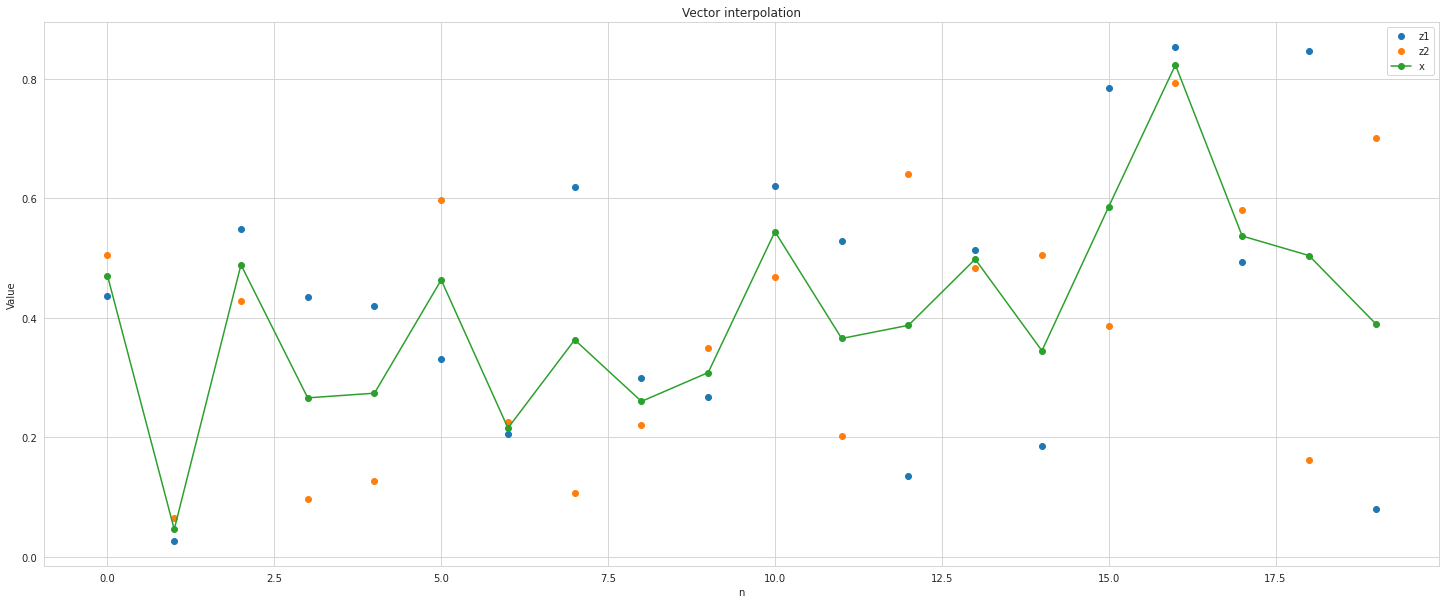

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig , ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)
np.random.seed(2)
x = [np.random.random(20),np.random.random(20)]

x_mu= np.mean(x, axis = 1)[...,np.newaxis]
s_fft = np.std(x, axis = 1)[...,np.newaxis]
Xmu_ = x - x_mu/s_fft

z = x[0] + x[1] 
z = 0.5 * z
d = {'x': x[0], 'y': x[1], 'z': z}
df = pd.DataFrame(d)
#print(df)
ax.plot(df.index,x[0], marker = 'o',linestyle = "None", label = 'z1')
ax.plot(df.index,x[1], marker = 'o', linestyle = "None", label = 'z2')
ax.plot(df.index,z, marker = 'o', label = 'x')
ax.set_title('Vector interpolation')
ax.set_xlabel('n')
ax.set_ylabel('Value')
ax.legend()
plt.show()


